In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

## Summary 

1. Clean infections data: if someone tests negative after testing positive, overwrite that result (assumes these are false negatives)
2. If a patient tests positive within three days of their admission to the facility, we assume they entered with an infection. Clean the data to back-date their start of infection time to admission

In [2]:
epi_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling'

In [3]:
infections = pd.read_csv(f"{epi_dir}/preprocessed/augmented/facility_trace.csv", index_col=0)
infections.columns = np.arange(367)
df_floor = pd.read_csv(f"{epi_dir}/preprocessed/augmented/floor_trace.csv", index_col=0)
df_floor.columns = np.arange(367)
df_room = pd.read_csv(f"{epi_dir}/preprocessed/augmented/room_trace.csv", index_col=0)
df_floor.columns = np.arange(367)

In [5]:
infections_cleaned = infections.copy()
messy_indices = []
for i, row in infections_cleaned.iterrows():
    infected = False
    for j, v in row.items():
        if infected:
            if v == 0:
                # does someone test negative after testing positive in a visit?
                # overwrite that test result
                row[j] = 1
                messy_indices.append(i)
        if v == 1:
            infected = True
        if np.isnan(v):
            infected = False
messy_indices = set(messy_indices)

In [6]:
messy_indices

{13, 92, 155, 162, 295}

It's possible that some of these are initial false positives, but we assume these are subsequent false negatives

In [7]:
facility_trace_old= pd.read_csv(f"{epi_dir}/data/2019-12-18_facility_trace.csv", index_col=0)
facility_trace_old.columns = np.arange(367)

In [9]:
never_infected_index = df_floor.index[260:]

In [10]:
# modify this: as long as old ftrace data is available, use that
df_screen = pd.DataFrame(index=df_floor.index, columns=df_floor.columns)
M = facility_trace_old.index.max()
for n, r in facility_trace_old.iterrows():
    entry_time = 0
    entered = False
    recorded = False
    for t, v in r.items():
        if v > 0 and not entered:
            # record entry time
            entry_time = t
            entered = True
        if entered and v == 0:
            # patient has exited facility
            entered = False
            recorded = False
        if v > 1 and not recorded:
            test_time = t - entry_time
            if test_time < 3:
                df_screen.loc[n, entry_time] = 1 if v == 1.5 else 0
                # fix this in infections cleaned?
                infections_cleaned.loc[n, entry_time] = 1 if v == 1.5 else 0
            else:
                df_screen.loc[n,entry_time] = 0
                infections_cleaned.loc[n, entry_time] = 0
            recorded = True

In [11]:
for n in never_infected_index:
    r = infections_cleaned.loc[n]
    entered = False
    for t, v in r.items():
        if not np.isnan(v) and not entered:
            entered = True
            df_screen.loc[n, t] = v
        if entered and np.isnan(v):
            entered = False

In [30]:
df_facility = (infections_cleaned.notna()).astype(int)

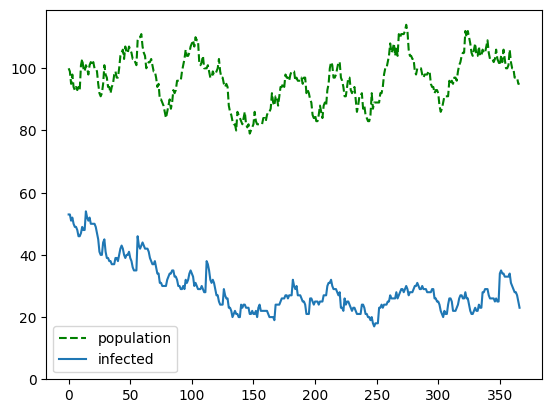

In [41]:
sns.lineplot(df_facility.sum(0), color="green", linestyle="--", label="population")
sns.lineplot(infections_cleaned.sum(0), label="infected")
plt.ylim(bottom=0)
plt.show()

In [ ]:
NN = df_facility.sum(0)
II = infections_cleaned.sum(0)

sns.lineplot(II / NN)
plt.ylim(bottom=0, top=1)

### Heterogeneous Observed Data

### Save

In [44]:
# write out data
output_dir = '/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/preprocessed'
infections_cleaned.to_csv(f"{output_dir}/infections.csv")
# with open(f"{output_dir}/observed_data.npy", "wb") as f:
#     np.save(f, observed_data)
df_screen.to_csv(f"{output_dir}/screening.csv")
df_facility.to_csv(f"{output_dir}/facility_trace.csv")
df_floor.to_csv(f"{output_dir}/floor_trace.csv")
df_room.to_csv(f"{output_dir}/room_trace.csv")